In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
df = pd.read_csv("KRW_IDR Historical Data JAN.csv")

# Bersihkan dan format data
df['Date'] = pd.to_datetime(df['Date'])

# Convert columns to string first if they're not already, then clean and convert to float
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Urutkan berdasarkan tanggal (dari terlama ke terbaru)
df = df.sort_values('Date')

df.head()

,Date,Price,Open,High,Low,Vol.,Change %
22,2025-01-01,10.874,10.8740,10.8740,10.8740,NaN,0.00
21,2025-01-02,10.999,10.9000,11.0780,10.8935,NaN,1.15
20,2025-01-03,11.015,11.0160,11.0875,10.9895,NaN,0.15
19,2025-01-06,11.051,11.0215,11.1305,10.9775,NaN,0.33
18,2025-01-07,11.066,11.0685,11.1685,11.0500,NaN,0.14


In [41]:
# Create figure
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Price'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

# Set layout with custom size
fig.update_layout(
    width=900,
    height=400,
    title='KRW/IDR Candlestick Chart - Januari 2025',
    xaxis_title='Tanggal',
    yaxis_title='Nilai Tukar (IDR)',
    xaxis_rangeslider_visible=False,
    template='plotly_white'
)

fig.show()

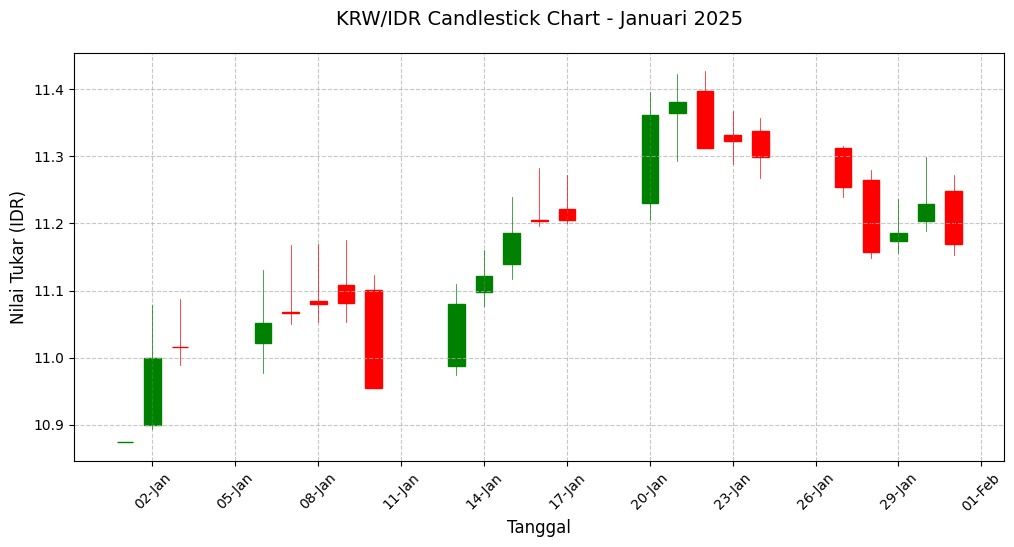

In [42]:
# Konversi format data untuk matplotlib
df['Date_num'] = mdates.date2num(df['Date'])
ohlc = df[['Date_num', 'Open', 'High', 'Low', 'Price']].values  # Price sebagai Close

plt.figure(figsize=(12, 6))  # figsize dalam inci (width, height)

# Buat candlestick chart
ax = plt.gca()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='green', colordown='red')

# Atur format dan styling
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)

plt.title('KRW/IDR Candlestick Chart - Januari 2025', fontsize=14, pad=20)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Nilai Tukar (IDR)', fontsize=12)

plt.subplots_adjust(bottom=0.2)

plt.show()

MSE Model: 0.01


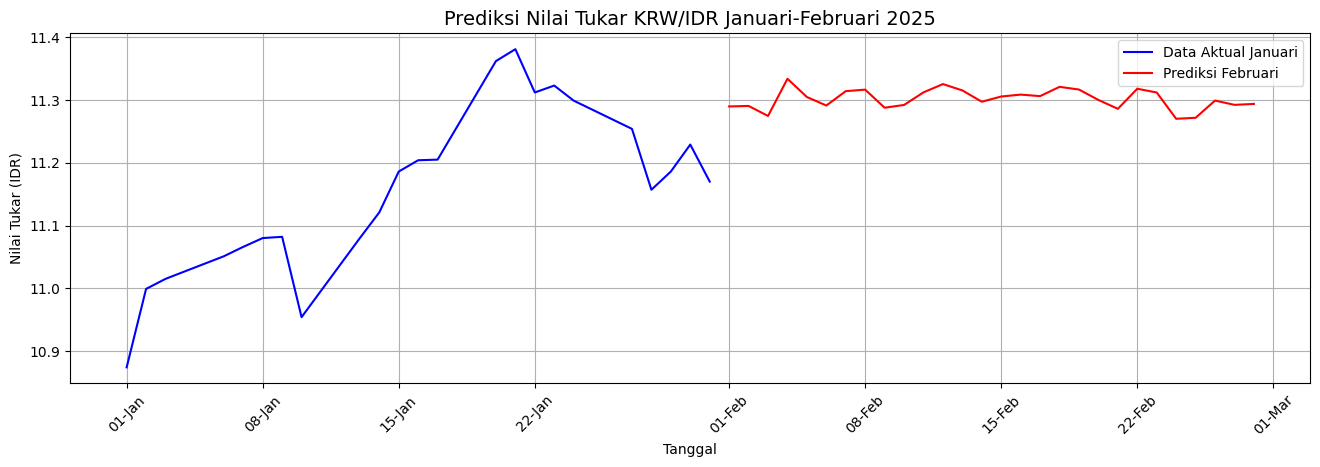

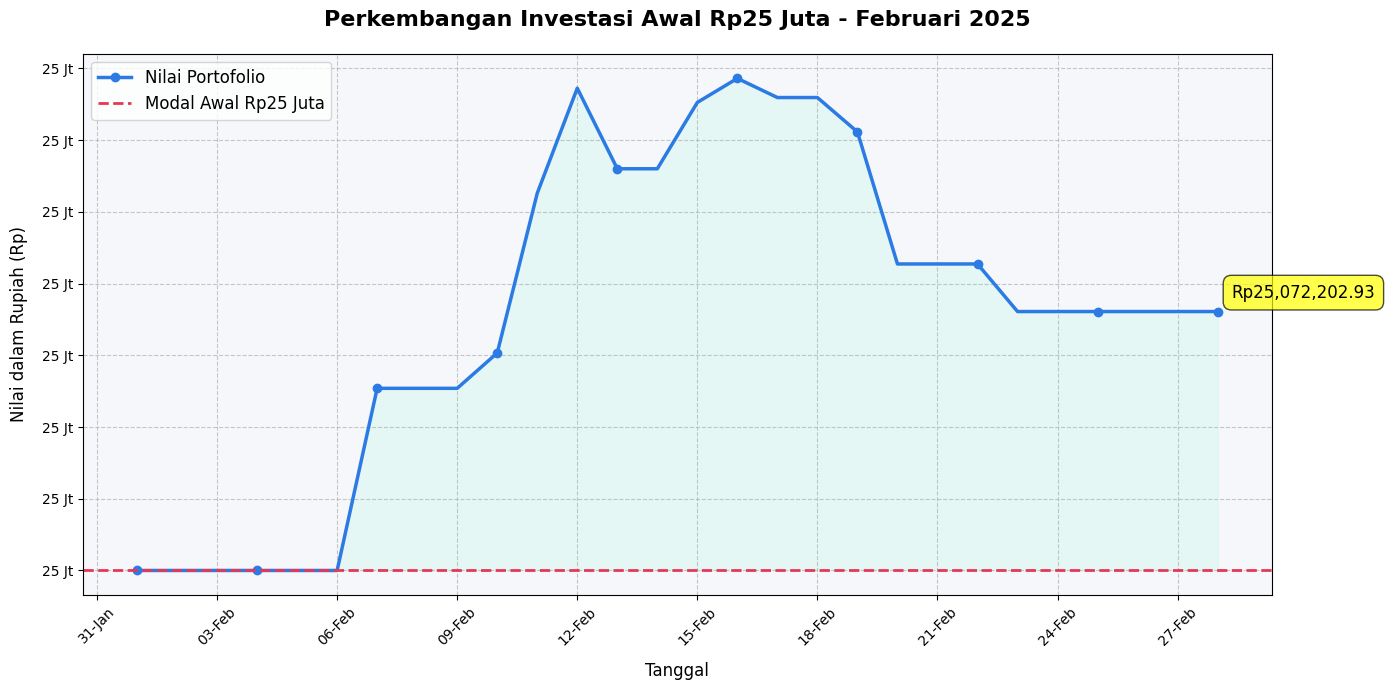

<Figure size 640x480 with 0 Axes>


=== Hasil Simulasi Trading ===
Modal awal: Rp25,000,000
Nilai akhir: Rp25,072,202.93
Keuntungan: Rp72,202.93 (0.29%)
Return Bulanan: 0.29%

Prediksi Februari telah disimpan ke file CSV


In [43]:
# Analisis Teknikal dengan Moving Average
df['MA5'] = df['Price'].rolling(window=5).mean()
df['MA10'] = df['Price'].rolling(window=10).mean()

# Membuat Model Prediksi
X = np.array(range(len(df))).reshape(-1, 1)  # Hari ke-n sebagai fitur
y = df['Price'].values  # Harga penutupan sebagai target

# Latih model regresi linear
model = LinearRegression()
model.fit(X, y)

# Prediksi untuk Januari (untuk evaluasi)
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print(f'MSE Model: {mse:.2f}')

# Prediksi untuk Februari 2025
feb_dates = pd.date_range(start='2025-02-01', end='2025-02-28')

# Prediksi dengan dua metode:
# Metode 1: Weighted Moving Average
last_ma5 = df['MA5'].iloc[-1]
last_ma10 = df['MA10'].iloc[-1]
pred_feb_wma = pd.DataFrame(index=feb_dates)
pred_feb_wma['Predicted'] = (last_ma5 * 0.6 + last_ma10 * 0.4) + np.random.normal(0, 0.03, 28)
pred_feb_wma['Predicted'] = pred_feb_wma['Predicted'].clip(lower=10.80, upper=11.40)

# Metode 2: Regresi Linear
X_feb = np.array(range(len(df), len(df)+len(feb_dates))).reshape(-1, 1)
feb_pred_lr = model.predict(X_feb)
pred_feb_lr = pd.DataFrame({'Date': feb_dates, 'Predicted': feb_pred_lr})
pred_feb_lr['Predicted'] = pred_feb_lr['Predicted'] + np.random.normal(0, 0.03, 28)
pred_feb_lr['Predicted'] = pred_feb_lr['Predicted'].clip(lower=10.80, upper=11.40)

# Gabungkan prediksi (kita akan menggunakan rata-rata kedua metode)
pred_feb = pd.DataFrame(index=feb_dates)
pred_feb['Predicted'] = (pred_feb_wma['Predicted'] + pred_feb_lr.set_index('Date')['Predicted']) / 2

# Simulasi Trading
initial_idr = 25000000  # Modal awal 25 juta
krw_balance = 0
idr_balance = initial_idr
daily_balance = []
daily_rates = []

for date, row in pred_feb.iterrows():
    current_rate = row['Predicted']
    daily_rates.append(current_rate)
    
    # Strategi berbasis moving average
    ma5_today = pred_feb.loc[:date]['Predicted'].rolling(window=5).mean().iloc[-1] if len(pred_feb.loc[:date]) >= 5 else current_rate
    ma10_today = pred_feb.loc[:date]['Predicted'].rolling(window=10).mean().iloc[-1] if len(pred_feb.loc[:date]) >= 10 else current_rate
    
    # Jika MA5 > MA10 (trend naik), beli USD
    if ma5_today > ma10_today and idr_balance > 0:
        krw_balance = idr_balance / current_rate
        idr_balance = 0
    # Jika MA5 < MA10 (trend turun), jual USD
    elif ma5_today < ma10_today and krw_balance > 0:
        idr_balance = krw_balance * current_rate
        krw_balance = 0
    
    daily_balance.append(idr_balance if idr_balance > 0 else krw_balance * current_rate)

# Hasil akhir
final_balance = daily_balance[-1]
profit = final_balance - initial_idr
profit_percentage = (profit / initial_idr) * 100

# Visualisasi
plt.figure(figsize=(16, 10))

# Plot data aktual dan prediksi
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Price'], label='Data Aktual Januari', color='blue')
plt.plot(pred_feb.index, pred_feb['Predicted'], label='Prediksi Februari', color='red')
plt.title('Prediksi Nilai Tukar KRW/IDR Januari-Februari 2025', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Nilai Tukar (IDR)')
plt.legend()
plt.grid(True)

# Format tanggal
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)

# Plot performa investasi
# Perbaikan visualisasi grafik perkembangan investasi
plt.figure(figsize=(14, 7))

# Plot garis perkembangan investasi
plt.plot(pred_feb.index, daily_balance, 
         label='Nilai Portofolio', 
         color='#2c7be5', 
         linewidth=2.5,
         marker='o',
         markersize=6,
         markevery=3)

# Garis modal awal
plt.axhline(y=initial_idr, 
            color='#e63757', 
            linestyle='--', 
            linewidth=2,
            label='Modal Awal Rp25 Juta')

# Area fill antara garis investasi dan modal awal
plt.fill_between(pred_feb.index, 
                 initial_idr, 
                 daily_balance, 
                 where=(np.array(daily_balance) > initial_idr),
                 color='#00ff9d10',
                 interpolate=True)

plt.fill_between(pred_feb.index, 
                 initial_idr, 
                 daily_balance, 
                 where=(np.array(daily_balance) < initial_idr),
                 color='#ff002b10',
                 interpolate=True)

# Formatting yang lebih baik
plt.title('Perkembangan Investasi Awal Rp25 Juta - Februari 2025', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.xlabel('Tanggal', fontsize=12, labelpad=10)
plt.ylabel('Nilai dalam Rupiah (Rp)', fontsize=12, labelpad=10)

# Format sumbu y ke dalam juta
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,} Jt".format(int(x/1e6))))

# Format tanggal di sumbu x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)

# Grid dan legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12)

# Warna background
plt.gca().set_facecolor('#f5f7fa')
plt.gcf().set_facecolor('#ffffff')

# Anotasi nilai akhir
end_val = daily_balance[-1]
plt.annotate(f'Rp{end_val:,.2f}', 
             xy=(pred_feb.index[-1], end_val),
             xytext=(10, 10), 
             textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
             fontsize=12)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# Hasil Simulasi
print("\n=== Hasil Simulasi Trading ===")
print(f"Modal awal: Rp{initial_idr:,}")
print(f"Nilai akhir: Rp{final_balance:,.2f}")
print(f"Keuntungan: Rp{profit:,.2f} ({profit_percentage:.2f}%)")
print(f"Return Bulanan: {profit_percentage:.2f}%")

# Simpan prediksi ke CSV
pred_feb.reset_index(inplace=True)
pred_feb.rename(columns={'index': 'Date'}, inplace=True)
pred_feb.to_csv('Prediksi_KRW_IDR_Februari_2025.csv', index=False)
print("\nPrediksi Februari telah disimpan ke file CSV")

=== Hasil Analisis Akurasi Prediksi ===
Jumlah Data yang Dibandingkan: 20 hari
Mean Absolute Error (MAE): 0.06
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.07
R-squared (R²): -0.3066
Mean Absolute Percentage Error (MAPE): 0.56%


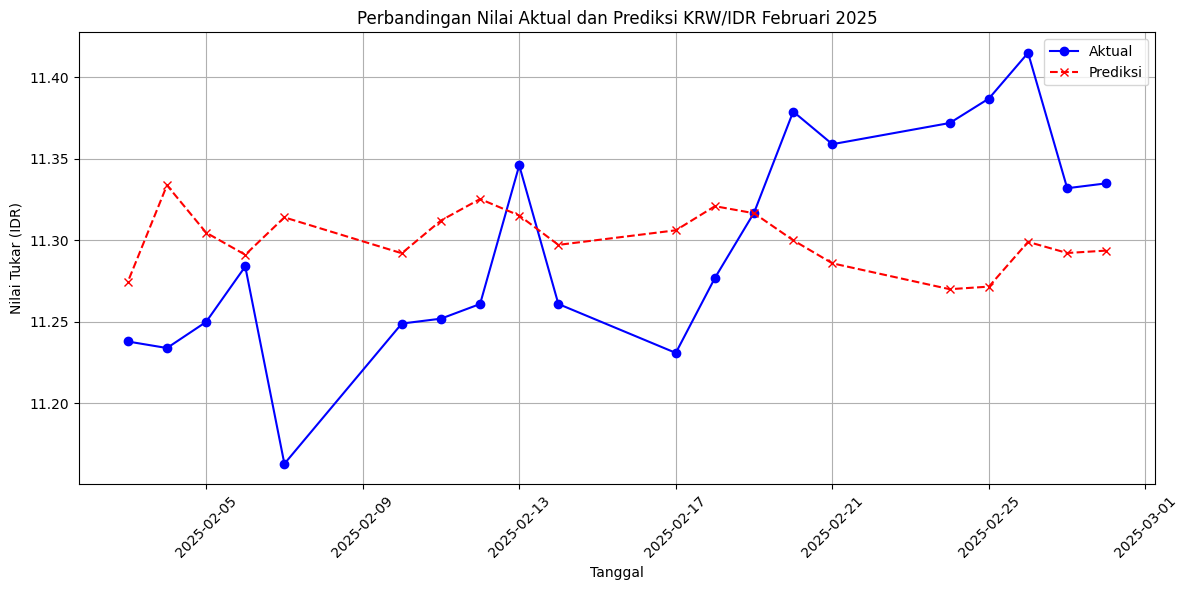


Tabel Perbandingan:
         Date   Price  Predicted   Selisih  Persentase Error
0  2025-02-28  11.335  11.293749  0.041251          0.363930
1  2025-02-27  11.332  11.292274  0.039726          0.350561
2  2025-02-26  11.415  11.299089  0.115911          1.015427
3  2025-02-25  11.387  11.271658  0.115342          1.012927
4  2025-02-24  11.372  11.270076  0.101924          0.896269
5  2025-02-21  11.359  11.285940  0.073060          0.643194
6  2025-02-20  11.379  11.300076  0.078924          0.693597
7  2025-02-19  11.317  11.316660  0.000340          0.003000
8  2025-02-18  11.277  11.320979  0.043979          0.389991
9  2025-02-17  11.231  11.306190  0.075190          0.669487
10 2025-02-14  11.261  11.297256  0.036256          0.321962
11 2025-02-13  11.346  11.315263  0.030737          0.270910
12 2025-02-12  11.261  11.325385  0.064385          0.571753
13 2025-02-11  11.252  11.312190  0.060190          0.534931
14 2025-02-10  11.249  11.292117  0.043117          0.383300
15 

In [44]:
# Import data aktual dari CSV
actual_df = pd.read_csv('KRW_IDR Historical Data FEB.csv')
# Konversi format angka dan tanggal
actual_df['Price'] = actual_df['Price'].astype(str).str.replace(',', '').astype(float)
actual_df['Date'] = pd.to_datetime(actual_df['Date'], format='%m/%d/%Y')

# Import data prediksi dari CSV
predicted_df = pd.read_csv('Prediksi_KRW_IDR_Februari_2025.csv')
# Coba beberapa format tanggal yang mungkin
try:
    predicted_df['Date'] = pd.to_datetime(predicted_df['Date'], format='%m/%d/%Y')
except ValueError:
    try:
        predicted_df['Date'] = pd.to_datetime(predicted_df['Date'], format='%Y-%m-%d')
    except ValueError:
        predicted_df['Date'] = pd.to_datetime(predicted_df['Date'], infer_datetime_format=True)

# Gabungkan data aktual dan prediksi berdasarkan tanggal
merged_df = pd.merge(actual_df, predicted_df, on='Date', how='inner')

# Hitung metrik akurasi
mae = mean_absolute_error(merged_df['Price'], merged_df['Predicted'])
mse = mean_squared_error(merged_df['Price'], merged_df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(merged_df['Price'], merged_df['Predicted'])
mape = np.mean(np.abs((merged_df['Price'] - merged_df['Predicted']) / merged_df['Price'])) * 100

# Tampilkan hasil metrik
print("=== Hasil Analisis Akurasi Prediksi ===")
print(f"Jumlah Data yang Dibandingkan: {len(merged_df)} hari")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualisasi perbandingan aktual vs prediksi
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Price'], 'b-', label='Aktual', marker='o')
plt.plot(merged_df['Date'], merged_df['Predicted'], 'r--', label='Prediksi', marker='x')
plt.title('Perbandingan Nilai Aktual dan Prediksi KRW/IDR Februari 2025')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Tukar (IDR)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tambahkan kolom perbandingan
merged_df['Selisih'] = np.abs(merged_df['Price'] - merged_df['Predicted'])
merged_df['Persentase Error'] = np.abs((merged_df['Price'] - merged_df['Predicted']) / merged_df['Price']) * 100

# Tampilkan tabel perbandingan
print("\nTabel Perbandingan:")
print(merged_df[['Date', 'Price', 'Predicted', 'Selisih', 'Persentase Error']].sort_values('Date', ascending=False))

# Simpan hasil perbandingan ke CSV
output_filename = 'Hasil_Perbandingan_KRW_IDR_Februari_2025.csv'
merged_df[['Date', 'Price', 'Predicted', 'Selisih', 'Persentase Error']].to_csv(output_filename, index=False)
print(f"\nHasil perbandingan telah disimpan ke file: {output_filename}")

# Tambahkan metrik evaluasi ke file CSV
metrics_df = pd.DataFrame({
    'Metric': ['Jumlah Data', 'MAE', 'MSE', 'RMSE', 'R-squared', 'MAPE'],
    'Value': [len(merged_df), mae, mse, rmse, r2, mape]
})
metrics_filename = 'Metrik_Evaluasi_Prediksi_KRW_IDR.csv'
metrics_df.to_csv(metrics_filename, index=False)
print(f"Metrik evaluasi telah disimpan ke file: {metrics_filename}")